In [2]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from util import *
from node import *
from optim import *
from net import Net

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def loadlabels(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n = struct.unpack(">ll", f.read(2*4))
        assert(_magic == 2049)
        return np.frombuffer(f.read(n), dtype=np.dtype("B"))

def loadimages(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n, sx, sy = struct.unpack(">llll", f.read(4*4))
        assert(_magic == 2051)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, sx, sy).astype(np.float32)/255.0
        return ((sx, sy), images)

def load(labelsfp, imagesfp):
    labels = loadlabels(labelsfp)
    size, images = loadimages(imagesfp)
    assert(labels.shape[0] == images.shape[0])
    return (size, labels, images)

In [4]:
ddir = "data/digits/"
print("loading train set")
imgsize, train_labels, train_images = load(ddir + "train-labels-idx1-ubyte.gz", ddir + "train-images-idx3-ubyte.gz")

print("loading test set")
_imgsize, test_labels, test_images = load(ddir + "t10k-labels-idx1-ubyte.gz", ddir + "t10k-images-idx3-ubyte.gz")

assert(imgsize == _imgsize)

loading train set
loading test set


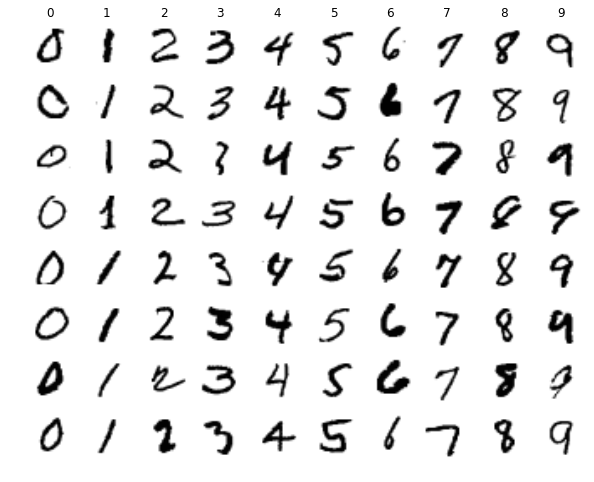

In [5]:
rows = 8
for digit in range(10):
    idxs = np.flatnonzero(np.equal(train_labels, digit))
    idxs = np.random.choice(idxs, rows, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(rows, 10, 10*i + digit + 1)
        plt.imshow(255.0*(1.0 - train_images[idx]))
        plt.axis('off')
        if i == 0:
            plt.title(digit)

In [34]:
def shuffle_set(labels, images):
    perm = np.random.permutation(labels.shape[0])
    return labels[perm], images[perm]

def plot(train, test):
    plt.subplot(2, 1, 1)
    plt.plot(train[0], train[1], test[0], test[1])
    plt.subplot(2, 1, 2)
    plt.plot(test[0], test[2])
    plt.yscale('log')
    plt.show()

In [48]:
sx, sh, sy = imgsize[0]*imgsize[1], 30, 10
layers = [Affine(sx, sh), Bias(sh), Tanh(), Affine(sh, sy), Bias(sy)]
links = [(i - 1, i) for i in range(len(layers))] + [(len(layers) - 1, -1)]
net = Net(layers, links)

In [49]:
epoch = 0
pos = 0
smooth_loss = None
train_history, test_history = [[], []], [[], [], []]

In [50]:
batch_size = 10
learning_rate = 1e-2
optim = SGD(learning_rate)

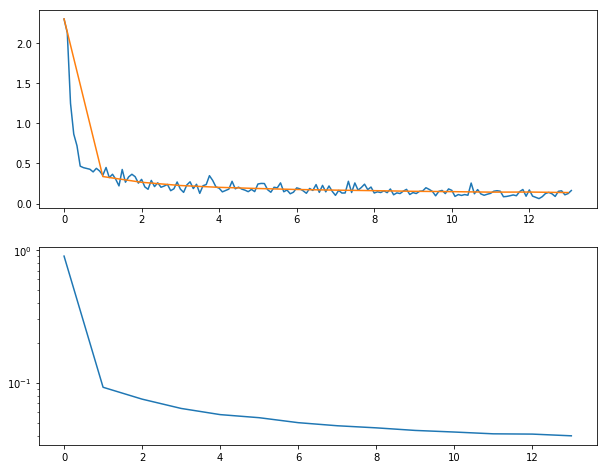

done


In [51]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

while not done:
    if pos == 0:
        _train_labels, _train_images = shuffle_set(train_labels, train_images)
    
    grad = net.newgrad()
    loss = 0.0
    for label, image in zip(_train_labels[pos:pos+batch_size], _train_images[pos:pos+batch_size]):
        y, m = net.feed_mem(image.reshape(-1))
        smy = softmax(y)
        dy = ce_softmax_deriv(smy, label)
        net.backprop(grad, m, dy)
        loss += ce_loss(smy, label)
    optim.learn(net, grad, batch_size=batch_size)
    loss /= batch_size
    
    if smooth_loss is None:
        smooth_loss = loss
    smooth_loss = 0.9*smooth_loss + 0.1*loss
    fepoch = epoch + pos/train_labels.shape[0]
    
    if pos == 0:
        loss = 0.0
        accuracy = 0
        for label, image in zip(test_labels, test_images):
            y = net.feed(image.reshape(-1))
            smy = softmax(y)
            loss += ce_loss(smy, label)
            accuracy += (np.argmax(y) == label)
        loss /= test_labels.shape[0]
        accuracy /= test_labels.shape[0]
        test_history[0].append(fepoch)
        test_history[1].append(loss)
        test_history[2].append(1.0 - accuracy)
        
    if (pos//batch_size) % 500 == 0:
        train_history[0].append(fepoch)
        train_history[1].append(smooth_loss)
        clear_output(wait=True)
        plot(train_history, test_history)
    
    pos += batch_size
    if pos >= train_labels.shape[0]:
        pos = 0
        epoch += 1

print("done")

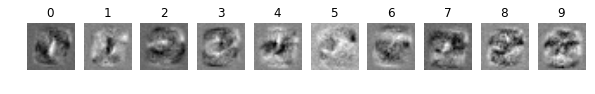

In [68]:
for label in range(10):
    image = np.random.random(imgsize[0]*imgsize[1])*1e-2
    for i in range(100):
        grad = net.newgrad()
        y, m = net.feed_mem(image)
        smy = softmax(y)
        dy = ce_softmax_deriv(smy, label)
        dx = net.backprop(grad, m, dy)
        image -= 1e-2*dx
    plt.subplot(1, 10, label + 1)
    plt.imshow(255.0*(1.0 - image.reshape(*imgsize)))
    plt.axis('off')
    plt.title(label)
plt.show()